In [1]:
# %% Libraries

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import os, glob, itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf
from networkx.algorithms import degree_centrality
from networkx.algorithms import eigenvector_centrality
from networkx.algorithms import betweenness_centrality
from sklearn.metrics.pairwise import cosine_similarity
from networkx.algorithms.community import girvan_newman, modularity
from networkx.algorithms.community import greedy_modularity_communities
from pprint import pprint as pp

In [2]:
# loading the xml file 
G = nx.read_graphml('trading_floor.xml')

In [3]:
# creating a dataframe
df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient="index")

/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_5825/2516197178.py:20: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  pp(nx.info(G))


'Graph with 192 nodes and 384 edges'


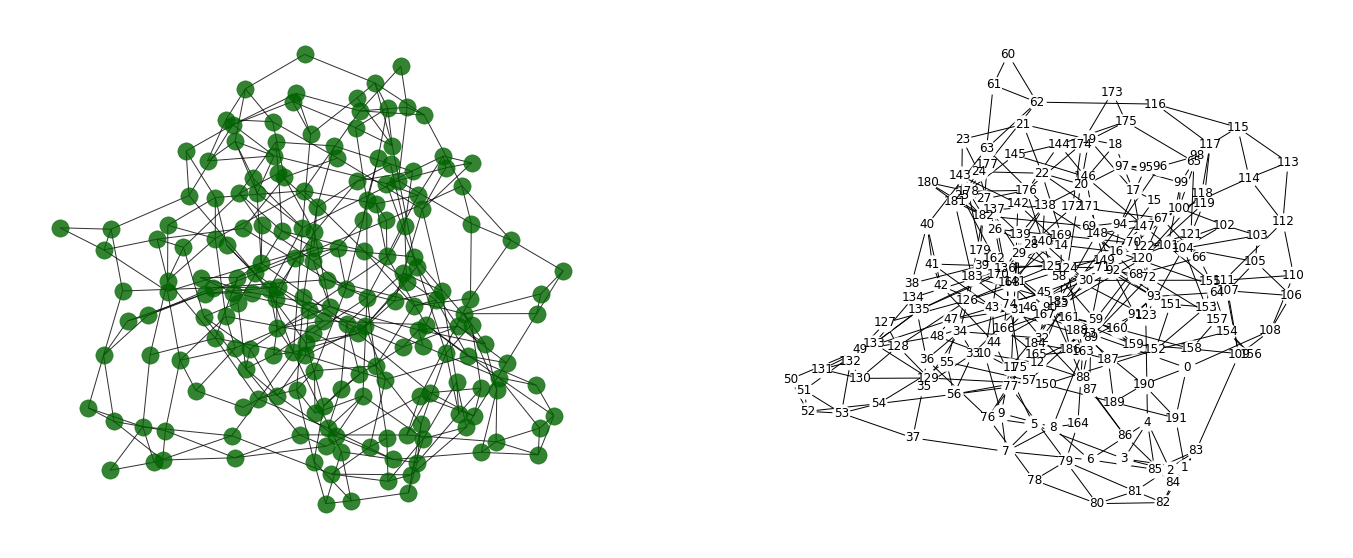

In [4]:
# -- + inspecting/plotting the network
fig = plt.figure(1, figsize=(24, 10))

pos = nx.layout.spring_layout(G)
ax0 = fig.add_subplot(1, 2, 1)
ax = fig.add_subplot(1, 2, 2)

options = {
    'node_color': 'darkgreen',
    'alpha': 0.8,
    'linewidths': 0.5,
    'with_labels': False,
    'font_color': 'black'
}
ax0.axis('off')
nx.draw_networkx(G, pos=pos, **options, ax=ax0)

# %% inspect the networkx
# basic info
pp(nx.info(G))

# --+ draw the network
pos = nx.spring_layout(G)
nx.draw(G, pos, alpha=1, node_color='white')
nx.draw_networkx_labels(G, pos, ax=ax)
plt.axis("off")

plt.show()

                        eigenvector_centrality  closeness_centrality  \
eigenvector_centrality                1.000000              0.704299   
closeness_centrality                  0.704299              1.000000   
betweenness_centrality                0.641171              0.811621   
degree_centrality                     0.676837              0.582143   

                        betweenness_centrality  degree_centrality  
eigenvector_centrality                0.641171           0.676837  
closeness_centrality                  0.811621           0.582143  
betweenness_centrality                1.000000           0.736532  
degree_centrality                     0.736532           1.000000  


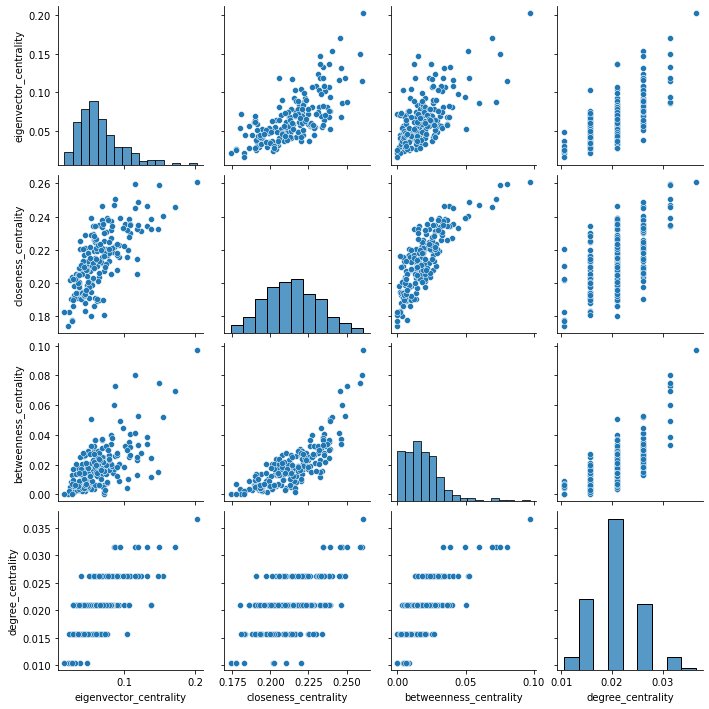

In [5]:
# Node distribution centrality plots
# --+ degree of node
degree = degree_centrality(G)
# --+ degree distribution
dc = nx.degree_centrality(G)
# --+ eigenvector_centrality
ec = nx.eigenvector_centrality(G)
# --+ closeness centrality
cc = nx.closeness_centrality(G)
# --+ betweeness centrality
bc = nx.betweenness_centrality(G)
# save to data frame
df1 = pd.DataFrame({
    'eigenvector_centrality': ec,
    'closeness_centrality': cc,
    'betweenness_centrality': bc,
    'degree_centrality': dc,
})
# --+ correlation matrix
print(df1.corr())
# --+ scatter plot matrix
sns.pairplot(df1, palette="RdBu_r")
plt.show()

In [6]:
# picking the node with the highest centralities measures
df1.idxmax(axis=0, skipna=True)

eigenvector_centrality    138
closeness_centrality      138
betweenness_centrality    138
degree_centrality         138
dtype: object

In [7]:
# printing it out 
print(df1.iloc[[138]])

     eigenvector_centrality  closeness_centrality  betweenness_centrality  \
138                0.202053              0.260929                0.096939   

     degree_centrality  
138           0.036649  


In [8]:
# merging the 2 dataframes
df = df.join(df1)

In [9]:
# max and min degree of the nodes
min_degree = min(degree.values())
max_degree = max(degree.values())
print(min_degree, max_degree)

0.010471204188481676 0.03664921465968587


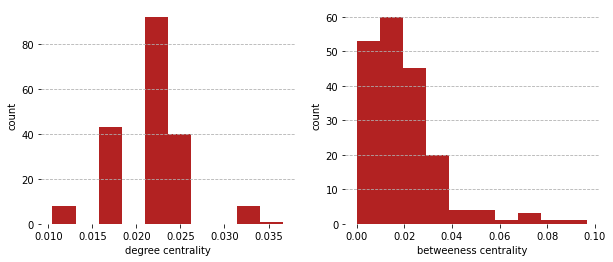

In [10]:
# --+ plot the degree centrality
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 2, 1)

ax.hist(list(degree.values()), color='firebrick')
ax.set_xlabel("degree centrality", fontsize=10)
ax.set_ylabel("count", fontsize=10)

ax.grid(ls='--', axis='y')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# --+ plot betweeness centrality
ax1 = fig.add_subplot(1, 2, 2)

ax1.hist(list(bc.values()), color="firebrick")
ax1.set_xlabel("betweeness centrality", fontsize=10)
ax1.set_ylabel("count", fontsize=10)

ax1.grid(ls='--', axis='y')
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

plt.show()

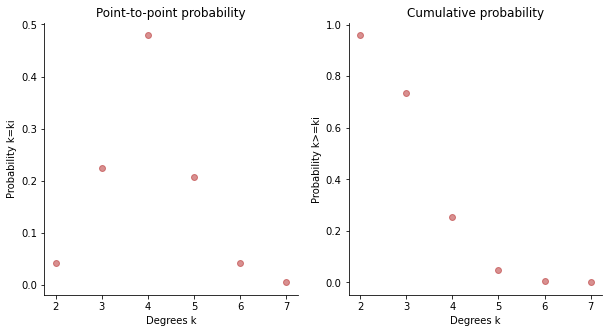

In [11]:
# --+ create a list with degree of each node
degrees = sorted([d for n, d in G.degree()], reverse=True)
degrees

pk = np.unique(degrees, return_counts=True)
cpk = np.unique(degrees, return_index=True)

# --+ visualising
fig = plt.figure(figsize=(10, 5))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

ax0.scatter(pk[0],
            pk[1] / len(degrees),
            marker='o',
            color='firebrick',
            alpha=0.5)
ax0.set_title('Point-to-point probability')
ax0.set_xlabel('Degrees k')
ax0.set_ylabel('Probability k=ki')
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

ax1.scatter(cpk[0],
            cpk[1] / len(degrees),
            marker='o',
            color='firebrick',
            alpha=0.5)
ax1.set_title('Cumulative probability')
ax1.set_xlabel('Degrees k')
ax1.set_ylabel('Probability k>=ki')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

plt.show(fig)

Produce Descriptive Statistics

In [12]:
# --+ converting the values of the dictionaries into lists
dc = (list(dc.values()))
bc = (list(bc.values()))
cc = (list(cc.values()))
ec = (list(ec.values()))

In [13]:
# --+ Show the descriptive statistics of Degree Centrality

print("""
==============================================
    Summary stats on Degree Centrality
==============================================
Mean  :       {:.2f}
Min   :       {:>5}
Max   :       {:>5}
Sigma :       {:.2f}
""".format(np.mean(list(dc)), np.min(list(dc)), np.max(list(dc)),
           np.std(list(dc))))

# --+ Show the descriptive statistics of Betweeness Centrality

print("""
==============================================
    Summary stats on Betweeness Centrality 
==============================================
Mean  :       {:.2f}
Min   :       {:>5}
Max   :       {:>5}
Sigma :       {:.2f}
""".format(np.mean(list(bc)), np.min(list(bc)), np.max(list(bc)),
           np.std(list(bc))))

# --+ Show the descriptive statistics of Closeness Centrality

print("""
==============================================
    Summary stats on Closeness Centrality 
==============================================
Mean  :       {:.2f}
Min   :       {:>5}
Max   :       {:>5}
Sigma :       {:.2f}
""".format(np.mean(list(cc)), np.min(list(cc)), np.max(list(cc)),
           np.std(list(cc))))

# --+ Show the descriptive statistics of Eigenvector Centrality

print("""
==============================================
    Summary stats on Eigenvector Centrality
==============================================
Mean  :       {:.2f}
Min   :       {:>5}
Max   :       {:>5}
Sigma :       {:.2f}
""".format(np.mean(list(ec)), np.min(list(ec)), np.max(list(ec)),
           np.std(list(ec))))


    Summary stats on Degree Centrality
Mean  :       0.02
Min   :       0.010471204188481676
Max   :       0.03664921465968587
Sigma :       0.00


    Summary stats on Betweeness Centrality 
Mean  :       0.02
Min   :         0.0
Max   :       0.09693929777140614
Sigma :       0.02


    Summary stats on Closeness Centrality 
Mean  :       0.21
Min   :       0.1741112123974476
Max   :       0.2609289617486339
Sigma :       0.02


    Summary stats on Eigenvector Centrality
Mean  :       0.07
Min   :       0.01569112458390006
Max   :       0.20205271460462126
Sigma :       0.03



# Assesing the modularity of the Network
Detecting communities using Girwan-Newman 

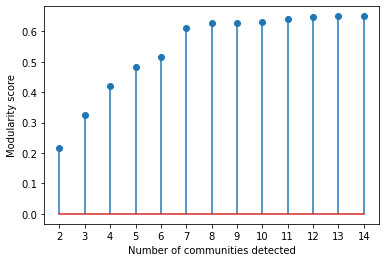

In [14]:
# --+ plotting with 13 communities
# fit
solutions = girvan_newman(G)
# --+ alternative paritioning solutions to consider
k = 13
# --+ register modularity scores
modularity_scores = dict()
# --+ iterate over solutions
for community in itertools.islice(solutions, k):
    solution = list(sorted(c) for c in community)
    score = modularity(G, solution)
    modularity_scores[len(solution)] = score
# --+ plot modularity data
fig = plt.figure()
pos = list(modularity_scores.keys())
values = list(modularity_scores.values())
ax = fig.add_subplot(1, 1, 1)
ax.stem(pos, values)
ax.set_xticks(pos)
ax.set_xlabel(r'Number of communities detected')
ax.set_ylabel(r'Modularity score')
plt.show()

Based on the modularity score the number of communitites detected on our dataset is 13

By using the greedy_modularity_communities function we are going to create a dataframe with the nodes and the community these nodes belong to

In [15]:
# finding how many communities this dataset has
communities = list(nx.algorithms.community.greedy_modularity_communities(G))

In [16]:
# the plot above shows us the same result as in community number 13 we have the highest modularity
len(communities)

13

So based on both different ways of detecting communities in our dataset, it is observed that the size of 13 communities gives us the highest score of modularity

Therefore, 13 communities are structured inside this large trading floor located in Canary Wharf

In [17]:
# creating a dataframe with nodes and in which community every node is detected
commu_df = pd.DataFrame.from_records(communities)

In [18]:
# renaming the rows into communities
commu_df = commu_df.rename(
    {
        0: '1',
        1: '2',
        2: '3',
        3: '4',
        4: '5',
        5: '6',
        6: '7',
        7: '8',
        8: '9',
        9: '10',
        10: '11',
        11: '12',
        12: '13'
    },
    axis='index')

Transforming our dataframe to make it easier for use 

In [19]:
# chaning the order of the rows to make it easier in use
df0 = commu_df.reset_index()

In [20]:
# renaming the columns
df0 = df0.rename(
    columns={
        0: 'cell.0',
        1: 'cell.1',
        2: 'cell.2',
        3: 'cell.3',
        4: 'cell.4',
        5: 'cell.5',
        6: 'cell.6',
        7: 'cell.7',
        8: 'cell.8',
        9: 'cell.9',
        10: 'cell.10',
        11: 'cell.11',
        12: 'cell.12',
        13: 'cell.13',
        14: 'cell.14',
        15: 'cell.15',
        16: 'cell.16',
        17: 'cell.17',
        18: 'cell.18',
        19: 'cell.19',
        20: 'cell.20',
        21: 'cell.21',
        22: 'cell.22'
    })

In [21]:
# --+ transforming our dataframe in order to be able to merge later
nodes = [c for c in df0 if c.startswith('cell.')]
df0 = pd.melt(df0, id_vars='index', value_vars=nodes, value_name='nodes')

In [22]:
# dropping the na rows
df0.dropna(inplace = True)

In [23]:
# transforming column nodes into integer
df0['nodes'] = df0['nodes'].astype(int)

In [24]:
# sorting values
df0.sort_values('nodes', inplace = True)

In [25]:
# adding a column to show in which community every node belongs
df['Community'] = df0['index'].to_numpy()

Now we can visualise in which community every node belongs 

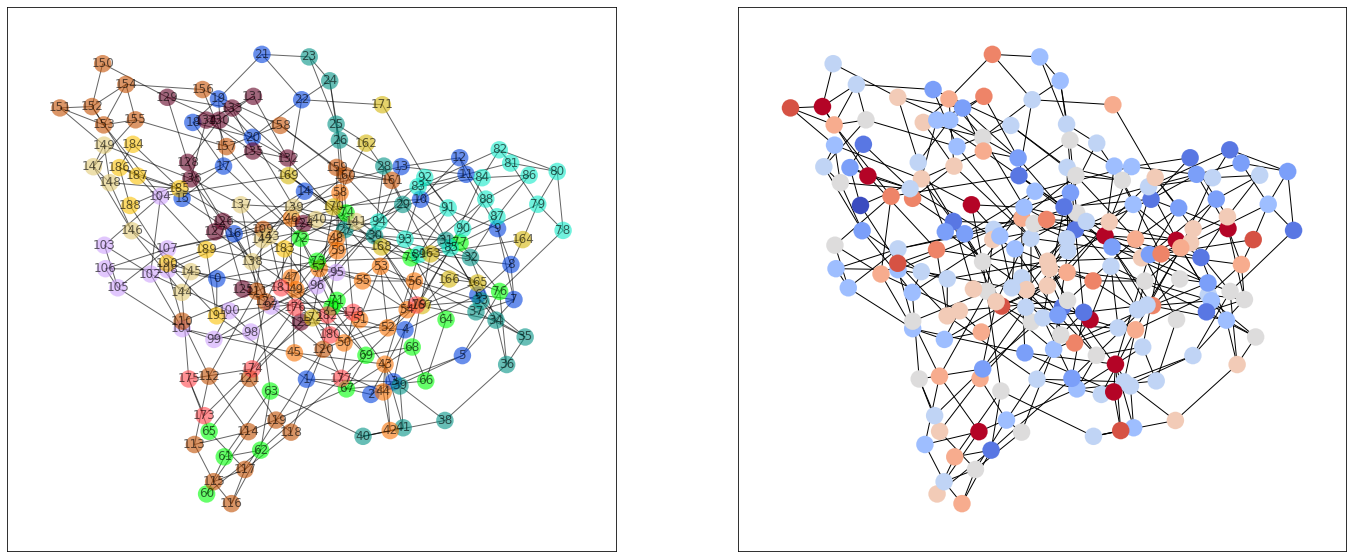

In [26]:
# --+ Visualisation of the communities
fig = plt.figure(1, figsize=(24, 10))
ax = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

pos = nx.layout.spring_layout(G)

colors = [
    '#0343df', '#029386', '#f97306', '#01ff07', '#13eac9', '#cea2fd',
    '#c04e01', '#610023', '#e2ca76', '#c65102', '#d5b60a', '#ff474c', '#fac205'
]

color_map = []
for i in range(len(communities)):
    for node in G.nodes():
        if node in communities[i]:
            color_map.append(colors[i])

options = {
    'node_color': color_map,
    'alpha': 0.6,
    'width': 1,
    'linewidths': 0.1,
    'with_labels': True,
    'font_color': 'black'
}

nx.draw_networkx(G, pos=pos, **options, ax=ax)
# --+ Visualisation of traders based on preference of adopting ai in the trading floor
options = {
    'node_color': df['ai'],
    'alpha': 1,
    'width': 1,
    'linewidths': 0.1,
    'with_labels': False,
    'font_color': 'black'
}

nx.draw_networkx(G, pos=pos, **options, cmap='coolwarm', ax=ax1)

Adding the position coordinates to our nodes

In [27]:
# adding the new column of the coordinates in our existing dataframe
df['position'] = df[['x_pos', 'y_pos']].apply(tuple, axis=1)

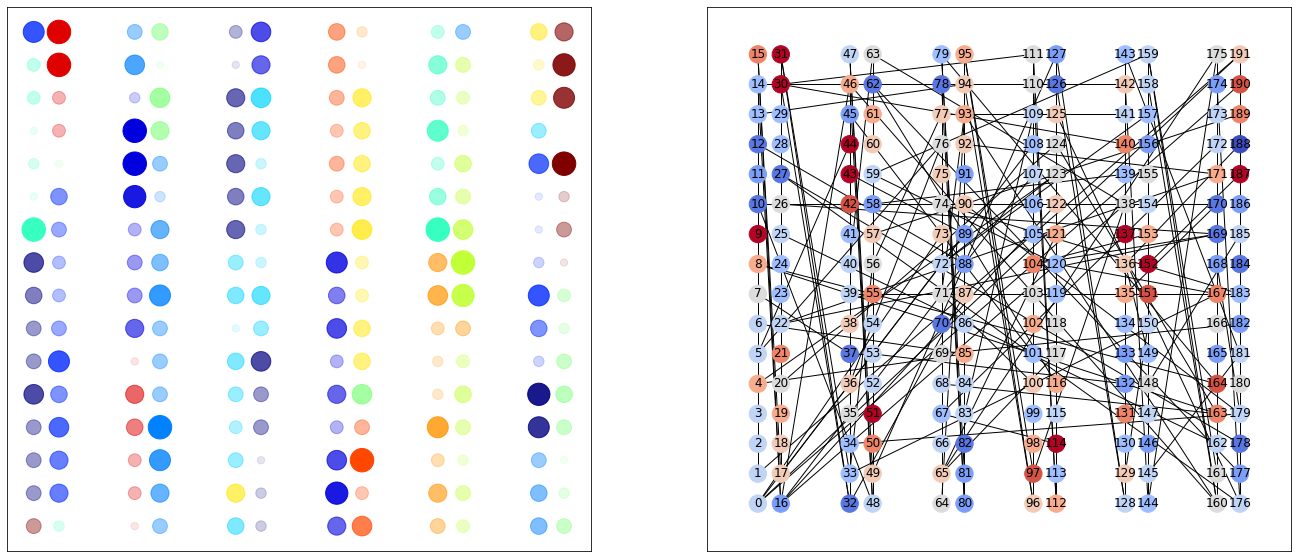

In [28]:
# --+ Visualisation based on the position of each node and the community that belongs to
fig = plt.figure(1, figsize=(23, 10))
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

pos = nx.layout.spring_layout(G)
# --+ coordinate & communities
nx.draw_networkx_nodes(G,
                       pos=df['position'],
                       node_color=df['Community'].apply(lambda x: int(x) - 1),
                       alpha=df['ai'] / 10,
                       node_size=df['ai'] * 55,
                       cmap=plt.cm.jet,
                       ax=ax0)
# --+ coordinates & ai preference
nx.draw_networkx(G,
                 pos=df['position'],
                 node_color=df['ai'],
                 cmap=plt.cm.coolwarm,
                 with_labels=True,
                 ax=ax1)
# --+ dark red means highest AI preference adoption

Before moving to our next step, let's analyse if distance between nodes in the trading floor(in combination with the community), play a significant role in adopting AI or no

In [29]:
# --+ dyadic similarity (based on preferences on adopting ai or no)
starting_point = []
ending_point = []
similarity = {}
score = []
for u, v in G.edges():
    key = "{}-{}".format(u, v)
    starting_point.append(u)
    ending_point.append(v)
    value = np.abs(G.nodes[u]["ai"] - G.nodes[v]["ai"])
    similarity[key] = value
    score.append(value)
# --+ score of similarity between the two nodes

# --+ creating a dataframe of the starting, ending point and the score of similarity between these two nodes
df_similarity = pd.DataFrame()
df_similarity['starting_point'] = pd.DataFrame(starting_point)
df_similarity['ending_point'] = pd.DataFrame(ending_point)
df_similarity['score'] = pd.DataFrame(score)
# --+ similarity score meaning how much difference in the preference of adopting AI two nodes have

In [30]:
# --+ creating a new dataframe with a starting-ending point (based on the x_pos and y_pos)
starting_x = []
starting_y = []
ending_x = []
ending_y = []
for i in starting_point:
    starting_x.append(df['x_pos'][i])
for i in starting_point:
    starting_y.append(df['y_pos'][i])
for i in ending_point:
    ending_x.append(df['x_pos'][i])
for i in ending_point:
    ending_y.append(df['y_pos'][i])

df_similarity['starting_x'] = starting_x
df_similarity['starting_y'] = starting_y
df_similarity['ending_x'] = ending_x
df_similarity['ending_y'] = ending_y

In [31]:
# --+ preparing to calculate the distance between the nodes
df_similarity['sq'] = (
    (df_similarity['starting_x'] - df_similarity['ending_x'])**2 +
    (df_similarity['starting_y'] - df_similarity['ending_y'])**2)

In [32]:
# --+ distance
df_similarity['distance'] = (df_similarity['sq'])**0.5
# --+ dropping unnecessary column
df_similarity.drop(['sq'], axis=1)

,starting_point,ending_point,score,starting_x,starting_y,ending_x,ending_y,distance
0,0,191,2,1,0,22,15,25.806976
1,0,190,5,1,0,22,14,25.238859
2,0,108,1,1,0,13,12,16.970563
3,0,73,2,1,0,9,9,12.041595
4,1,2,0,1,1,1,2,1.000000
...,...,...,...,...,...,...,...,...
379,187,189,2,22,11,22,13,2.000000
380,188,190,9,22,12,22,14,2.000000
381,189,190,1,22,13,22,14,1.000000
382,189,191,2,22,13,22,15,2.000000


<AxesSubplot:xlabel='score', ylabel='distance'>

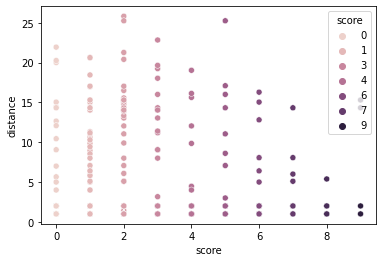

In [33]:
# --+ visualise distance - similarity
sns.scatterplot(x='score', y='distance', hue='score', data=df_similarity)

In [34]:
# --+ running OLS regression
x = df_similarity['score']
y = df_similarity['distance']
FML = 'y ~ x'
OLS = smf.ols(FML, data=df_similarity).fit()
print(OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.03668
Date:                Sat, 02 Jul 2022   Prob (F-statistic):              0.848
Time:                        22:45:31   Log-Likelihood:                -1222.2
No. Observations:                 384   AIC:                             2448.
Df Residuals:                     382   BIC:                             2456.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8162      0.463     10.405      0.0

# Diffusion and Cascading 

In [35]:
# --+ creating a function for the diffusion-cascading process
def difussion(n):
    df['Adopters'] = (df['ai'] >= n)

    p = df['Adopters']
    for i in sorted(G.nodes()):
        G.nodes[i]['adopting'] = p[i]

    colors = []
    for i in G.nodes():
        if G.nodes[i]['adopting'] == True:
            colors.append('green')
        else:
            colors.append('grey')
# creating the figure
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 2, 1)
    ax0 = fig.add_subplot(1, 2, 2)
    ax.axis('off')

    nx.draw_networkx(G,
                     pos=df['position'],
                     with_labels=False,
                     node_color=colors,
                     edge_color='black',
                     node_size=df['ai'] * 45,
                     ax=ax,
                     alpha=0.5)

    # ---+ calculating the percentage of traders before the diffusion
    adopters = nx.get_node_attributes(G, 'adopting')
    adopt = []
    for i in adopters.values():
        adopt.append(i)

    print("The percentage of traders in adopting AI before diffusion is",
          str(round(np.mean(adopt) * 100)) + '%.')
    # --+ initialize the diffusion process
    # nodes making decisions
    for focal in G.nodes:
        # --+ pay-off of adopting the new behavior
        a = 1 + df['ai'][focal] / 10
        # --+ pay-off of the status quo (not changing)
        b = 1 + (1 - (df['ai'][focal] / 10))
        # count adopting neighbors
        focal_nbrs = list(G.neighbors(focal))
        p = np.sum([G.nodes[nbr]['adopting'] for nbr in focal_nbrs])
        # pay-off of adopting new behavior
        d = G.degree(focal)
        a_payoff = p * a
        b_payoff = (d - p) * b
        # decision to adopt
        if (G.nodes[focal]['adopting'] == False) & (a_payoff > b_payoff):
            G.nodes[focal]['adopting'] = True
        else:
            pass


# %% draw the network (green are the early adopters based on the score they range in ai column)
    colors = []
    for n in G.nodes():
        if G.nodes[n]['adopting'] == True:
            colors.append('green')
        else:
            colors.append('grey')

    nx.draw(G,
            pos=df['position'],
            with_labels=False,
            node_color=colors,
            node_size=df['ai'] * 45,
            ax=ax0,
            alpha=0.9)

    # ---+ calculating the percentage of traders of adopting AI
    adopters = nx.get_node_attributes(G, 'adopting')
    adopt = []
    for i in adopters.values():
        adopt.append(i)

    print("The percentage of traders in adopting AI after difussion is",
          str(round(np.mean(adopt) * 100)) + "%.")
    return difussion

The percentage of traders in adopting AI before diffusion is 33%.
The percentage of traders in adopting AI after difussion is 44%.


<function __main__.difussion(n)>

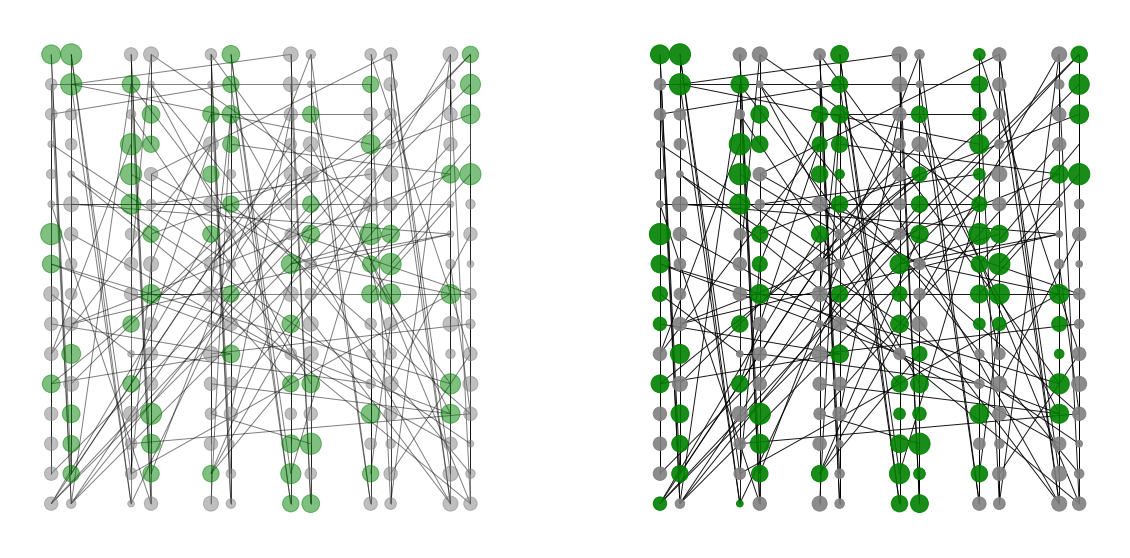

In [37]:
# --+ the function
difussion(6)